Google Collab for 612 final project with reddit climate change dataset.

In [98]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2023-12-15 03:56:31--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2023-12-15 03:56:31--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

2023-12-15 03:56:31 (27.3 MB/s) - written to stdout [1191/1191]

Installing

In [99]:
import sparknlp
spark = sparknlp.start(gpu=True)

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 5.2.0
Apache Spark version: 3.2.3


In [100]:
from google.colab import drive
drive.mount('/content/drive')

# !ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import of reddit climate change comment dataset from google drive.

In [101]:
df = spark.read.csv("/content/drive/My Drive/Colab Notebooks/the-reddit-climate-change-dataset-comments.csv", header=True, inferSchema=True, escape='"', multiLine = True)

print("The number of rows in the dataset is: ", df.count())

df.show(5)


The number of rows in the dataset is:  4600698
+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit.id|subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------+--------------+-----------+--------------------+--------------------+---------+-----+
|comment|imlddn9|       2qh3l|          news|         false| 1661990368|https://old.reddi...|Yeah but what the...|   0.5719|    2|
|comment|imldbeh|       2qn7b|          ohio|         false| 1661990340|https://old.reddi...|Any comparison of...|  -0.9877|    2|
|comment|imldado|       2qhma|    newzealand|         false| 1661990327|https://old.reddi...|I'm honestly wait...|  -0.1143|    1|
|comment|imld6cb|       2qi09|    sacramento|         false| 1661990278|https://old.reddi...|Not just Sacramen...|      0.0|    4|
|comment|imld0kj|       2qh1i|     a

Data Preprocessing (Check duplicates, nulls etc.).

In [102]:
from pyspark.sql.functions import col, count

# Since the id is a unique identifier if there is a duplicate it means the row needs to be removed

# Group by 'id' and count the occurrences
id_counts = df.groupBy("id").agg(count("id").alias("count"))

# Filter out the ids that occur only once
duplicates = id_counts.filter(col("count") > 1)

# Count the number of duplicated ids
num_duplicates = duplicates.count()

# If num_duplicates = 0, we have made sure there are no duplicates and the data has been cleaned
print(f"Number of duplicated ids: {num_duplicates}")

Number of duplicated ids: 0


In [103]:
# Check for null values in each column

feature_cols = ['sentiment','score']

for col_name in feature_cols:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"Column {col_name} has {null_count} null values")

# Handle null values, for example, by dropping rows with nulls
df = df.na.drop(subset=feature_cols)

Column sentiment has 57131 null values


In [104]:
df = df.drop("subreddit.id", "subreddit.name", "subreddit.nsfw", "id", "type", "permalink")
df.show(1)

+-----------+--------------------+---------+-----+
|created_utc|                body|sentiment|score|
+-----------+--------------------+---------+-----+
| 1661990368|Yeah but what the...|   0.5719|    2|
+-----------+--------------------+---------+-----+
only showing top 1 row



Some EDA.

In [105]:
from pyspark.sql.functions import mean

# Calculate the mean score
mean_score = df.select(mean('score')).collect()[0][0]

print(f"The mean score is: {mean_score}")

The mean score is: 9.594097324855118


In [106]:
# Calculate the mean sentiment
mean_sentiment = df.select(mean('sentiment')).collect()[0]

mean_sentiment_value = mean_sentiment[0]

print(f"The mean sentiment is: {mean_sentiment_value}")

The mean sentiment is: -0.005827451977706207


In [107]:
from pyspark.sql.functions import from_unixtime

df = df.withColumn('created_datetime', from_unixtime('created_utc'))
df.show(5)

+-----------+--------------------+---------+-----+-------------------+
|created_utc|                body|sentiment|score|   created_datetime|
+-----------+--------------------+---------+-----+-------------------+
| 1661990368|Yeah but what the...|   0.5719|    2|2022-08-31 23:59:28|
| 1661990340|Any comparison of...|  -0.9877|    2|2022-08-31 23:59:00|
| 1661990327|I'm honestly wait...|  -0.1143|    1|2022-08-31 23:58:47|
| 1661990278|Not just Sacramen...|      0.0|    4|2022-08-31 23:57:58|
| 1661990206|I think climate c...|   0.6634|    1|2022-08-31 23:56:46|
+-----------+--------------------+---------+-----+-------------------+
only showing top 5 rows



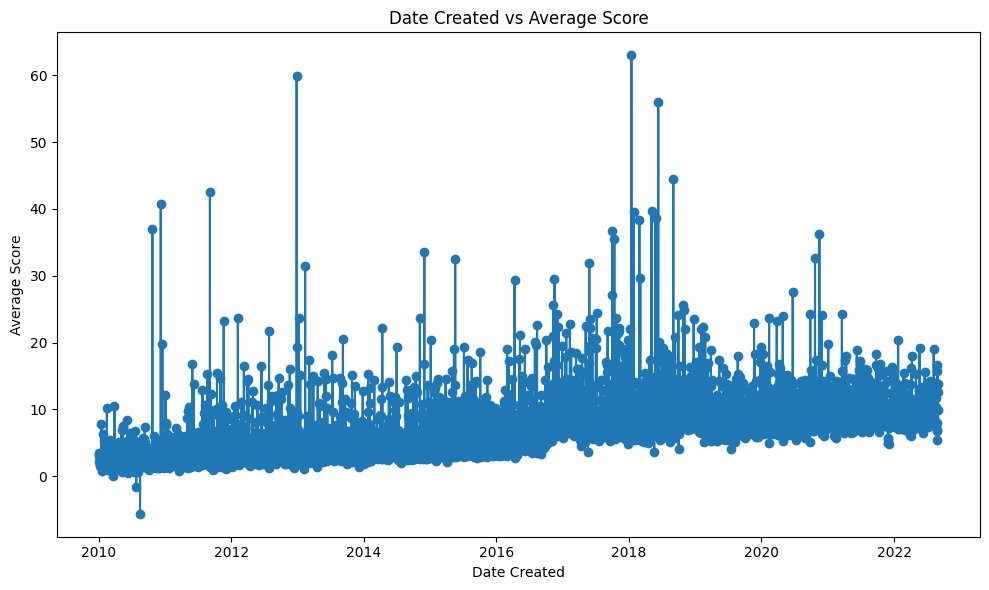

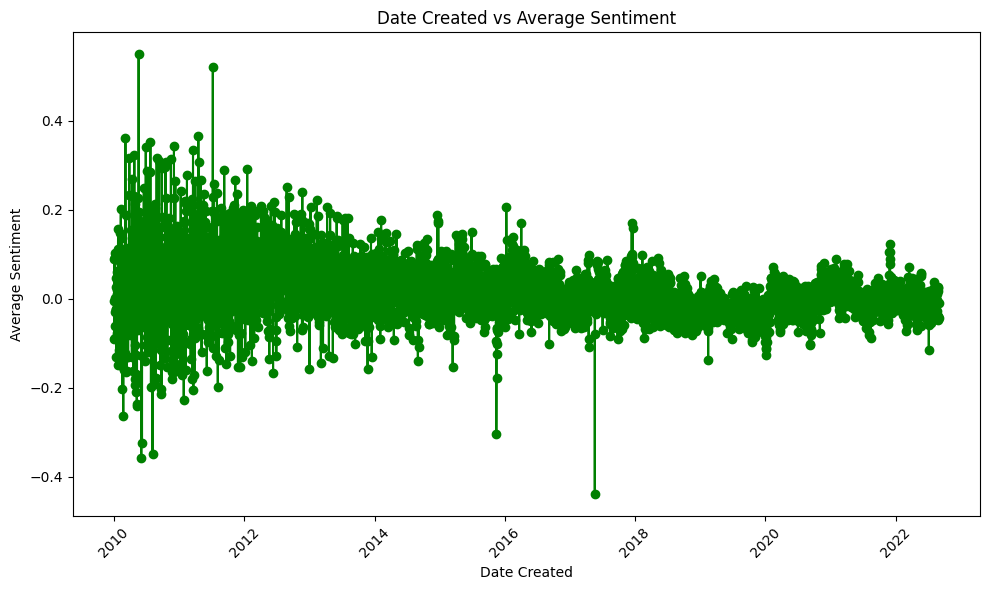

In [108]:
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'created_datetime' to a date format (without time)
df = df.withColumn('date', to_date('created_datetime'))

# Aggregate the data by date
df_agg = df.groupBy('date').agg({'score': 'mean', 'sentiment': 'mean'}).toDF('date', 'avg_score', 'avg_sentiment')

# Convert to Pandas DataFrame for plotting
pandas_df = df_agg.toPandas()

# Sorting by date for better visualization
pandas_df.sort_values(by='date', inplace=True)

# Plotting 'date created vs score'
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['date'], pandas_df['avg_score'], marker='o')
plt.xlabel('Date Created')
plt.ylabel('Average Score')
plt.title('Date Created vs Average Score')
plt.tight_layout()
plt.show()

# Plotting 'date created vs sentiment'
plt.figure(figsize=(10, 6))
plt.plot(pandas_df['date'], pandas_df['avg_sentiment'], marker='o', color='green')
plt.xlabel('Date Created')
plt.ylabel('Average Sentiment')
plt.title('Date Created vs Average Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Testing of models.

Tested linear regression, random forest regression and gradient boosted regression models with sentiment as feature and score as target. Results were very poor (r2 of 0).

In [109]:
#added to speed up running of notebook, tried models with full dataset and still got very poor results
df = df.limit(1000)

In [110]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Assembler to convert features into a vector
assembler = VectorAssembler(inputCols=['sentiment'], outputCol='features')
model_df = assembler.transform(df)

(training_data, test_data) = model_df.randomSplit([0.8, 0.2], seed=1234)

# Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='score')

# Fit the model to the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 18.239790353485525
R2 on test data = -0.035734050998866396


In [111]:
from pyspark.ml.regression import RandomForestRegressor

# Random Forest Regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
rf_model = rf.fit(training_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 21.638618230058967
R2 on test data = -0.45769820609662926


In [112]:
from pyspark.ml.regression import GBTRegressor

# Gradient Boosted Tree model
gbt = GBTRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
gbt_model = gbt.fit(training_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 21.531875148977125
R2 on test data = -0.4433520577857608


Tested linear regression, random forest regression and gradient boosted regression models with created_utc as feature and score as target. Results were very poor (r2 of 0).

In [113]:
# Vector Assembler to create a feature vector
vector_assembler = VectorAssembler(inputCols=["created_utc"], outputCol="features")
time_model_df = vector_assembler.transform(df)

# Split the data into training and testing sets
total_rows = time_model_df.count()
split_percentage = 0.8
split_index = int(total_rows * split_percentage)
split_timestamp = time_model_df.orderBy("created_datetime").collect()[split_index]["created_datetime"]

# Split the data based on the timestamp
training_data = time_model_df.filter(col("created_datetime") < split_timestamp)
test_data = time_model_df.filter(col("created_datetime") >= split_timestamp)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")

# Fit the model to the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 51.8922
R2 on test data = -0.00155581


In [114]:

# Random Forest Regressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
rf_model = rf.fit(training_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 51.85291329421951
R2 on test data = -4.0110624484945845e-05


In [115]:

# Gradient Boosted Tree model
gbt = GBTRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
gbt_model = gbt.fit(training_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 51.88169074914222
R2 on test data = -0.0011504279889904545


Added word_count and hour as columns.
Tested linear regression, random forest regression and gradient boosted regression models with word_count as feature and score as target. Results were very poor (r2 of 0).

In [116]:
from pyspark.sql.functions import  date_format, split, size, hour

# Tokenize the "body" column and count the words
df = df.withColumn("word_count", size(split(col("body"), " ")))

df = df.withColumn('time_only', date_format('created_datetime', 'HH:mm:ss'))

df = df.withColumn("hour", hour("time_only"))

df.show(5)

+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+
|created_utc|                body|sentiment|score|   created_datetime|      date|word_count|time_only|hour|
+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+
| 1661990368|Yeah but what the...|   0.5719|    2|2022-08-31 23:59:28|2022-08-31|        53| 23:59:28|  23|
| 1661990340|Any comparison of...|  -0.9877|    2|2022-08-31 23:59:00|2022-08-31|       242| 23:59:00|  23|
| 1661990327|I'm honestly wait...|  -0.1143|    1|2022-08-31 23:58:47|2022-08-31|        68| 23:58:47|  23|
| 1661990278|Not just Sacramen...|      0.0|    4|2022-08-31 23:57:58|2022-08-31|        18| 23:57:58|  23|
| 1661990206|I think climate c...|   0.6634|    1|2022-08-31 23:56:46|2022-08-31|        78| 23:56:46|  23|
+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+
only showing top 5 rows



In [117]:
# Vector Assembler to create a feature vector
vector_assembler = VectorAssembler(inputCols=["word_count"], outputCol="features")
word_count_df = vector_assembler.transform(df)

# Split the data into training and testing sets
(training_data, test_data) = word_count_df.randomSplit([0.8, 0.2], seed=1234)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")

# Fit the model to the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 18.107
R2 on test data = -0.0207073


In [118]:
# Random Forest Regressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
rf_model = rf.fit(training_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 20.578491740284488
R2 on test data = -0.31836495967128964


In [119]:
# Gradient Boosted Tree model
gbt = GBTRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
gbt_model = gbt.fit(training_data)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(gbt_predictions)
r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 20.63146583857626
R2 on test data = -0.32516128735864047


Tested linear regression, random forest regression and gradient boosted regression models with hour as feature and score as target. Results were very poor (r2 of 0).

In [120]:
# Vector Assembler to create a feature vector
vector_assembler = VectorAssembler(inputCols=["hour"], outputCol="features")
hour_df = vector_assembler.transform(df)

# Split the data into training and testing sets
(training_data, test_data) = hour_df.randomSplit([0.8, 0.2], seed=1234)

# Create a Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="score")

# Fit the model to the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 18.23
R2 on test data = -0.0346212


In [121]:
# Random Forest Regressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
rf_model = rf.fit(training_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 18.65694296719914
R2 on test data = -0.08365125361380854


Attempted NLP below. Trained a NLP pipeline to get get embedding values for documents and averaged the into a single value called mean value to use as a feature. Tested linear regression, random forest regression and gradient boosted regression models with mean_value as feature and score as target. Results were very poor (r2 of 0).

In [122]:
df = df.withColumnRenamed("body", "text")
df.show(20)

+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+
|created_utc|                text|sentiment|score|   created_datetime|      date|word_count|time_only|hour|
+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+
| 1661990368|Yeah but what the...|   0.5719|    2|2022-08-31 23:59:28|2022-08-31|        53| 23:59:28|  23|
| 1661990340|Any comparison of...|  -0.9877|    2|2022-08-31 23:59:00|2022-08-31|       242| 23:59:00|  23|
| 1661990327|I'm honestly wait...|  -0.1143|    1|2022-08-31 23:58:47|2022-08-31|        68| 23:58:47|  23|
| 1661990278|Not just Sacramen...|      0.0|    4|2022-08-31 23:57:58|2022-08-31|        18| 23:57:58|  23|
| 1661990206|I think climate c...|   0.6634|    1|2022-08-31 23:56:46|2022-08-31|        78| 23:56:46|  23|
| 1661990120|Naaa how could an...|     0.25|    1|2022-08-31 23:55:20|2022-08-31|        16| 23:55:20|  23|
| 1661990114|Can i suggest m

In [123]:
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler() \
.setInputCol("text") \
.setOutputCol("document")

tokenizer = Tokenizer() \
.setInputCols("document") \
.setOutputCol("token")

stopWords = StopWordsCleaner.pretrained() \
    .setInputCols(["token"]) \
    .setOutputCol("cleanTokens")

embedding = WordEmbeddingsModel.pretrained()\
    .setInputCols(["document", "cleanTokens"]) \
    .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
    .setInputCols(["document", "embeddings"]) \
    .setOutputCol("sentence_embeddings") \
    .setPoolingStrategy("AVERAGE")

embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCols("finished_embeddings") \
    .setOutputAsVector(False) \
    .setCleanAnnotations(True)

pipeline = Pipeline().setStages([documentAssembler, tokenizer, stopWords, embedding, embeddingsSentence, embeddingsFinisher]).fit(df)

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [124]:
result = pipeline.transform(df)

In [125]:
result.show(5)

+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+--------------------+
|created_utc|                text|sentiment|score|   created_datetime|      date|word_count|time_only|hour| finished_embeddings|
+-----------+--------------------+---------+-----+-------------------+----------+----------+---------+----+--------------------+
| 1661990368|Yeah but what the...|   0.5719|    2|2022-08-31 23:59:28|2022-08-31|        53| 23:59:28|  23|[[-0.09582342, 0....|
| 1661990340|Any comparison of...|  -0.9877|    2|2022-08-31 23:59:00|2022-08-31|       242| 23:59:00|  23|[[-0.20790112, 0....|
| 1661990327|I'm honestly wait...|  -0.1143|    1|2022-08-31 23:58:47|2022-08-31|        68| 23:58:47|  23|[[-0.11997872, 0....|
| 1661990278|Not just Sacramen...|      0.0|    4|2022-08-31 23:57:58|2022-08-31|        18| 23:57:58|  23|[[-0.12475941, 0....|
| 1661990206|I think climate c...|   0.6634|    1|2022-08-31 23:56:46|2022-08-31|        78| 23:5

In [126]:
from pyspark.sql.functions import explode

exploded_df = result.select("score", explode("finished_embeddings").alias("exploded_values"))
exploded_df.show(5)

+-----+--------------------+
|score|     exploded_values|
+-----+--------------------+
|    2|[-0.09582342, 0.1...|
|    2|[-0.20790112, 0.3...|
|    1|[-0.11997872, 0.2...|
|    4|[-0.12475941, 0.1...|
|    1|[-0.20102279, 0.1...|
+-----+--------------------+
only showing top 5 rows



In [127]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, ArrayType

# Define a UDF to calculate the mean of an array
def calculate_mean(array):
    return float(sum(array) / len(array))

# Register the UDF
mean_udf = udf(calculate_mean, FloatType())

# Use withColumn to add a new column with the mean value
result_df = exploded_df.withColumn("mean_value", mean_udf(col("exploded_values")))

# Show the result
result_df.show()

+-----+--------------------+------------+
|score|     exploded_values|  mean_value|
+-----+--------------------+------------+
|    2|[-0.09582342, 0.1...|-0.015499057|
|    2|[-0.20790112, 0.3...|-0.010763373|
|    1|[-0.11997872, 0.2...| -0.03411759|
|    4|[-0.12475941, 0.1...|-0.048009343|
|    1|[-0.20102279, 0.1...|-0.015153618|
|    1|[-0.14186335, 0.0...|-0.044525065|
|    2|[0.026436167, 0.2...| -0.03495606|
|    2|[0.044403348, 0.2...|-0.037703075|
|    3|[-0.26011565, 0.1...|-0.023646705|
|    4|[-0.15710258, 0.3...|-0.029719327|
|    2|[0.054771744, 0.1...| -0.02009017|
|    6|[0.028553477, 0.2...|-0.021028062|
|    9|[-0.15107563, 0.2...|-0.014143329|
|    1|[-0.05951702, 0.1...|-0.030367365|
|    5|[-0.07641856, 0.1...| -0.02141611|
|    5|[-0.095410675, 0....|-0.028634444|
|    9|[-0.15260033, 0.1...|-0.033587657|
|    4|[-0.17434004, 0.3...|-0.024662444|
|    4|[-0.021459669, 0....|-0.029583476|
|    3|[-0.16735928, 0.1...|-0.026951225|
+-----+--------------------+------

In [128]:
result_df.drop("exploded_values")

# Assembler to convert features into a vector
assembler = VectorAssembler(inputCols=['mean_value'], outputCol='features')
assembled_result_df = assembler.transform(result_df)

(training_data, test_data) = assembled_result_df.randomSplit([0.8, 0.2], seed=1234)

# Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='score')

# Fit the model to the training data
lr_model = lr.fit(training_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 19.461655438241053
R2 on test data = -0.0764616065230519


In [129]:
from pyspark.ml.regression import RandomForestRegressor

# Linear Regression model
rf = RandomForestRegressor(featuresCol='features', labelCol='score')

# Fit the model to the training data
rf_model = rf.fit(training_data)

# Make predictions on the test data
rf_predictions = rf_model.transform(test_data)

# Evaluate the model using RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")

# Compute RMSE and R2 on test data
rmse = evaluator_rmse.evaluate(rf_predictions)
r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 20.65469376688765
R2 on test data = -0.21248536972218335


Since features we have and extracted have no correlation to Score, next steps would be to perform encoding on other text based features such as subredit.name and also look at other ways to use embedding values besides just the average (dig deeper into NLP).